Kaggle Dataset Google Drive에 저장

In [13]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AI/.kaggle/"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
cd /content/drive/MyDrive/AI/.kaggle

/content/drive/MyDrive/AI/.kaggle


In [17]:
!kaggle datasets download -d yasserhessein/gender-dataset


100% 1.32G/1.32G [00:47<00:00, 35.9MB/s]
100% 1.32G/1.32G [00:47<00:00, 29.8MB/s]


In [18]:
!unzip gender-dataset.zip
!ls

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Dataset/Validation/Male/189675.jpg  
  inflating: Dataset/Validation/Male/189676.jpg  
  inflating: Dataset/Validation/Male/189679.jpg  
  inflating: Dataset/Validation/Male/189681.jpg  
  inflating: Dataset/Validation/Male/189684.jpg  
  inflating: Dataset/Validation/Male/189688.jpg  
  inflating: Dataset/Validation/Male/189689.jpg  
  inflating: Dataset/Validation/Male/189691.jpg  
  inflating: Dataset/Validation/Male/189692.jpg  
  inflating: Dataset/Validation/Male/189693.jpg  
  inflating: Dataset/Validation/Male/189694.jpg  
  inflating: Dataset/Validation/Male/189695.jpg  
  inflating: Dataset/Validation/Male/189696.jpg  
  inflating: Dataset/Validation/Male/189697.jpg  
  inflating: Dataset/Validation/Male/189698.jpg  
  inflating: Dataset/Validation/Male/189702.jpg  
  inflating: Dataset/Validation/Male/189704.jpg  
  inflating: Dataset/Validation/Male/189705.jpg  
  inflating: Dataset/Validation/Male/189708.jpg  
  inflating: D

In [19]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [20]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [21]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [23]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/AI/.kaggle/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( '/content/drive/MyDrive/AI/.kaggle/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 159986 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [24]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

58889256/58889256 [==============================] - 2s 0us/step


In [10]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [11]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 2, 2, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         589952    
                                                        

In [12]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

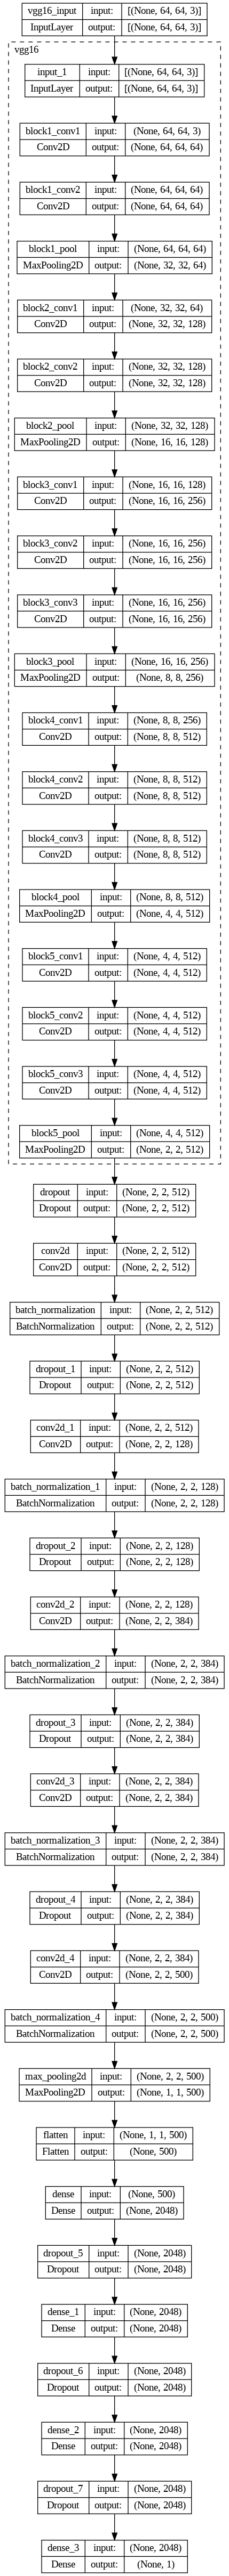

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [14]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [15]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


<ipython-input-15-3bc3d617dcc8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


Epoch 1/8
256/256 [==============================] - 80s 257ms/step - loss: 0.6812 - accuracy: 0.6512 - val_loss: 1.0367 - val_accuracy: 0.3857 - lr: 0.0010
Epoch 2/8
256/256 [==============================] - 68s 265ms/step - loss: 0.5248 - accuracy: 0.7425 - val_loss: 0.4224 - val_accuracy: 0.7999 - lr: 0.0010
Epoch 3/8
256/256 [==============================] - 71s 277ms/step - loss: 0.3538 - accuracy: 0.8470 - val_loss: 0.4517 - val_accuracy: 0.8119 - lr: 0.0010
Epoch 4/8
256/256 [==============================] - 76s 297ms/step - loss: 0.2699 - accuracy: 0.8899 - val_loss: 0.4687 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 5/8
256/256 [==============================] - 72s 280ms/step - loss: 0.2368 - accuracy: 0.9044 - val_loss: 0.2520 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 6/8
256/256 [==============================] - 76s 296ms/step - loss: 0.2086 - accuracy: 0.9175 - val_loss: 0.2041 - val_accuracy: 0.9280 - lr: 0.0010
Epoch 7/8
256/256 [==============================] - 76s 2

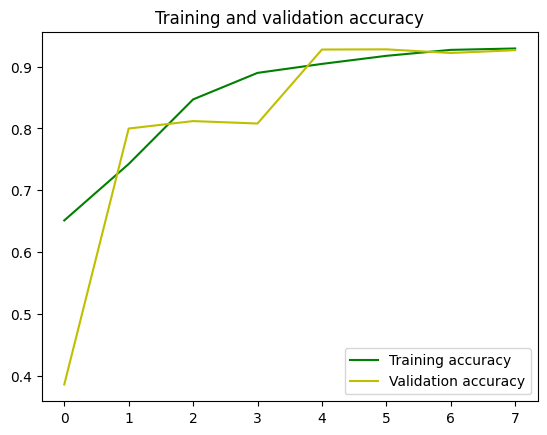

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 18ms/step
[0.8936872]
This  is a female


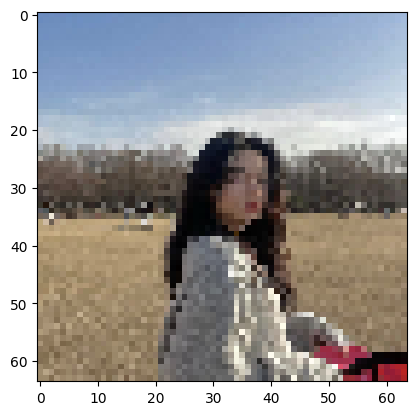

In [26]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "/content/test1.jpg"
imge = tf.keras.utils.load_img(path_testmodel, target_size = target_size)
X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

1/1 [==============================] - 0s 29ms/step
[4.7874117e-16]
This is a male


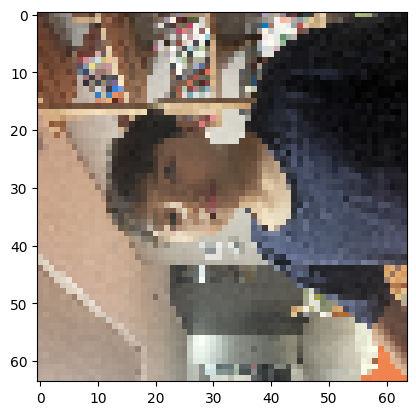

In [28]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "/content/test2.jpeg"
imge = tf.keras.utils.load_img(path_testmodel, target_size = target_size)
X = tf.keras.utils.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)